In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets,transforms
from torch.autograd import Variable

from IPython import display
from utils import Logger

In [2]:
data_folder = './torch_data/DCGAN/CIFAR'

## Loading data

In [6]:
def cifar_data():
    
    compose = transforms.Compose([transforms.Resize(64),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ])
    out_dir = '{}/dataset'.format(data_folder)
    
    return datasets.CIFAR10(root = out_dir,train = True,transform = compose,download = True)

In [8]:
data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data,batch_size = batch_size,shuffle = True)
num_batches = len(data_loader)

171MB [03:40, 862kB/s]                                                                                                                                                 

Files already downloaded and verified


# Defining Discriminator and Generator Networks

In [20]:
class DiscriminatorNet(nn.Module):
    
    def __init__(self):
        
        super(DiscriminatorNet,self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 128,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 1024,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.out = nn.Sequential(
            nn.Linear(1024*4*4,1),
            nn.Sigmoid())
        
    def forward(self,x):
        # Propagating through the layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # We need to flatten to pass through the last layer
        x = x.view(-1,1024*4*4)
        x = self.out(x)
        
        return x

In [24]:
class GeneratorNet(nn.Module):
    
    def __init__(self):
        
        super(GeneratorNet,self).__init__()
        
        self.linear = nn.Linear(100,1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 1024,out_channels = 512,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512,out_channels = 256,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256,out_channels = 128,kernel_size = 4,stride = 2,padding = 1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace = True))
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 128,out_channels = 3,kernel_size = 4,stride = 2,padding = 1,bias = False))
        
        self.out = nn.Tanh()
        
    def forward(self,x):
        # Propagating through the layers
        x = self.linear(x)
        x = x.view(x.shape[0],1024,4,4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        
        return x
    
def noise(size):
    n = Variable(torch.randn(size,100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [25]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Creating network instances and initializing weights

In [26]:
generator = GeneratorNet()
generator.apply(init_weights)

discriminator = DiscriminatorNet()
discriminator.apply(init_weights)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

# Optimizers and Loss Functions

In [27]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(),lr = 0.0001)
g_optimizer = Adam(generator.parameters(),lr = 0.0001)

# loss Functions
loss = nn.BCELoss()

# Epochs
num_epochs = 100

## Training

In [28]:
def real_data_target(size):

    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):

    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [30]:
def train_discriminator(optimizer,real_data,fake_data):
    
    # resetting gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real,real_data_target(real_data.size(0)))
    error_real.backward()
    
    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake,fake_data_target(fake_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real+error_fake,prediction_real,prediction_fake

In [31]:
def train_generator(optimizer,fake_data):
    # resetting gradients
    optimizer.zero_grad() 
    
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generating test samples

In [32]:
num_test_samples = 16
test_noise = noise(num_test_samples)

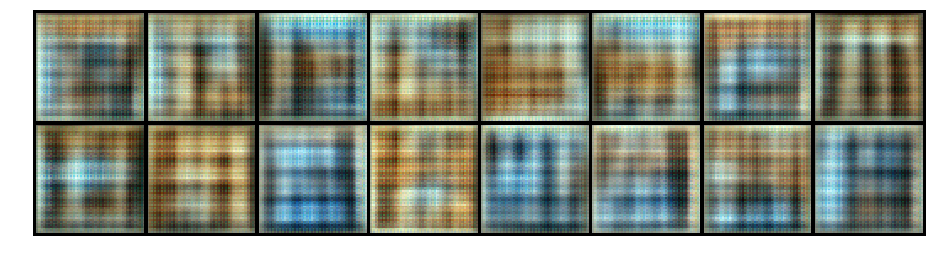

Epoch: [0/100], Batch Num: [0/500]
Discriminator Loss: 0.1037, Generator Loss: 7.8306
D(x): 0.9351, D(G(z)): 0.0057


KeyboardInterrupt: 

In [39]:
logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()

        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)

        # Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

# Checking the availability of GPU 

In [34]:
torch.cuda.current_device()

0

In [35]:
torch.cuda.device(0)

In [36]:
torch.cuda.device_count()

1

In [37]:
torch.cuda.get_device_name(0)

'GeForce 940M'